In [ ]:
!pip install git+https://github.com/inikishev/mrid
!pip install hd-bet # for skullstripping
!pip install SimpleITK-SimpleElastix # for registration

# Data
For this example we download some MRIs from https://zenodo.org/records/7213153 in DICOM format

Colin Vanden Bulcke. (2022). Open-Access DICOM MRI session (1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7213153


In [1]:
import os, shutil, requests
from pathlib import Path

if "data" not in os.listdir("./"):

    # download
    response = requests.get("https://zenodo.org/records/7213153/files/BMAT_MRI_session.zip?download=1", stream=True)
    response.raise_for_status()
    with open("data.zip", 'wb') as file:
        shutil.copyfileobj(response.raw, file) # type:ignore

    # unpack
    shutil.unpack_archive("data.zip", "data")

ROOT = Path("data/BMAT_MRI_session/export/home1/sdc_image_pool/images/p883/e1007")
os.listdir(ROOT)

['s16342',
 's16335',
 's16343',
 's16329',
 's16341',
 's16340',
 's16336',
 's16337',
 's16328',
 's16330']

# Creating a study
A `Study` is a dictionary with all scans, segmentations and other info.

Segmentations should have keys starting with `"seg"`, for example `"seg_brain"`. Segmentations are not affected by some methods like `normalize`, and during registration they use nearest neighbour interpolation to keep them binarized.

Info is any extra information, like patient ID, and should have keys starting with `"info"`, for example `"info_id"`. Info is preserved by all methods and isn't affected by them.

When you create a study, you can pass paths to nii/nii.gz files, paths to directories (assumed to be DICOM dir, make sure you only have 1 3D scan in the directory), SimpleITK Images, numpy arrays and torch.Tensors. Study converts everything to `sitk.Image` which retains spatial information from DICOMs and NIfTIs. In our case data is DICOMs.

We can also use `plot` method to get a basic idea of what the scans look like.

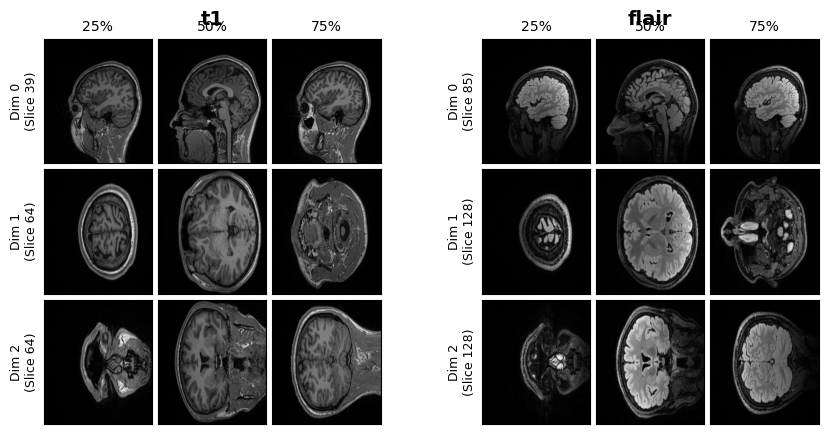

In [2]:
import mrid
study = mrid.Study(t1=ROOT/"s16329", flair=ROOT/"s16340", info_id=1)
study.plot()

# Registration
`Study` has many useful methods for registration, skullstripping, etc.

Note that all methods return a new study! They never modify a study in-place.

First we will register this to SRI24 space. Since scans in the study are not aligned, we can use `register_each` method to first register T1 to SRI24, and then all other scans (in our case FLAIR) to T1. You can use `mrid.get_mni152` and `mrid.get_sri24` which can download those templates.

 If all scans are already aligned, one can use `register` method which registers one scan, and applies the same transform to all other scans.

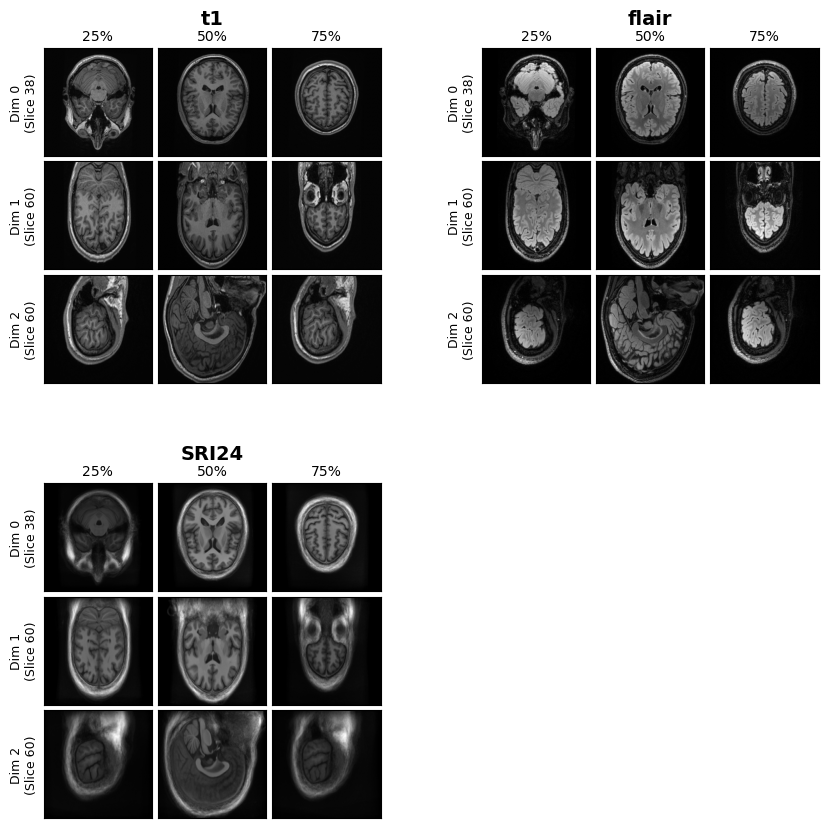

In [3]:
study_sri24 = study.register_each("t1", to=mrid.get_sri24("T1"))

# plot with SRI24
study_sri24.add("SRI24", mrid.get_sri24("T1")).plot()

# Skullstripping
Now that the scans are aligned, we can run skullstripping. This uses HD-BET model (https://github.com/MIC-DKFZ/HD-BET). It works with pre/post contrast T1, T2 and FLAIR MRIs, but it expects them to be in MNI152 space (while many new datasets like BraTS are in SRI24). The `skullstrip` method can register specified scan to MNI152, pass it to HD-BET, and then register back to original space, if `register_to_mni152` argument is specified.

We pass T1 to HD-BET and the predicted mask is used to extract the brain from all scans in the study, make sure scans are aligned before running skullstripping.

You should be able to run HD-BET on GPU if you have 4GB VRAM, it takes up to 2 minutes. If running on CPU its significantly slower, I recommend passing `disable_tta=True`, but it might still take 10-30 minutes. I passed it because I ran this on Colab.

2009a T1w symmetric False.nii.gz will be downloaded from https://zenodo.org/records/15470657, this may take a few minutes.

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

There are 1 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict

Predicting output_bet.nii.gz:
perform_everything_on_device: True


100%|██████████| 12/12 [01:23<00:00,  6.97s/it]


sending off prediction to background worker for resampling and export
done with output_bet.nii.gz


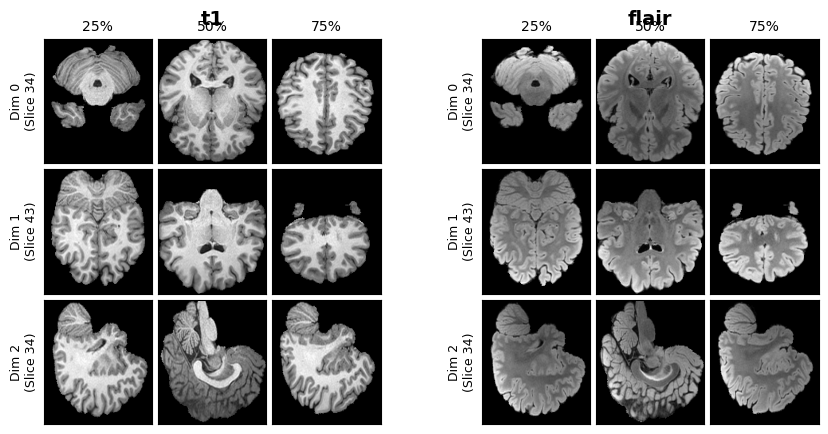

In [ ]:
study_skullstripped = study_sri24.skullstrip_mri("t1", register_to_mni152="T1", disable_tta=True).crop_bg("t1")
study_skullstripped.plot()

# Bias field correction
N4 bias field correction can be applied by calling `n4_bias_field_correction`. It is only applied to one scan under specified key.

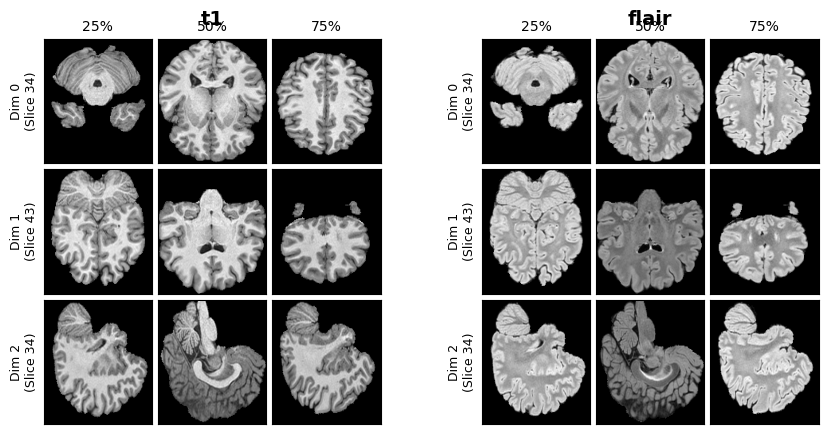

In [6]:
study_n4 = study_skullstripped.n4_bias_field_correction("t1").n4_bias_field_correction("flair")
study_n4.plot()

# Adding new images to studies
Suppose you obtained a segmentation and want to add it to the study, use the `study.add` method. Note that like all other methods, it returns a new study!

If segmentation is a numpy array or a torch tensor, it has no spatial information. But since segmentation is aligned to the scan that was segmented, you can copy spatial information from the scan by passing `reference_key`.

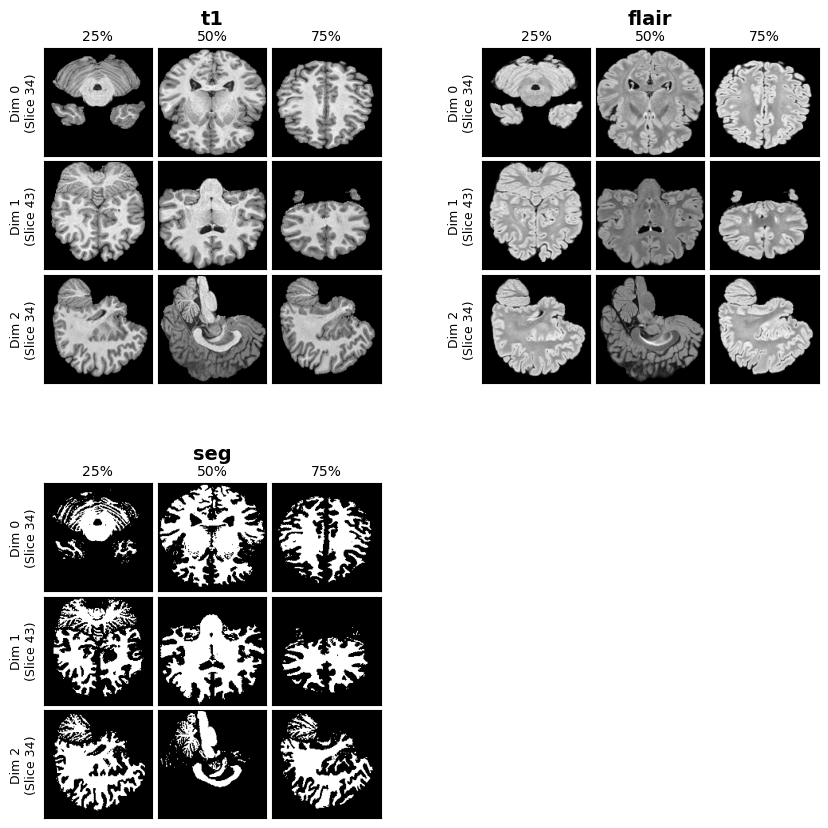

In [7]:
import numpy as np

seg = (study_n4.normalize().numpy("t1") > 1).astype(np.uint8)
study_with_seg = study_n4.add("seg", seg, reference_key="t1")
study_with_seg.plot()

# Moving back to original space

Now suppose we want to resample this segmentation to original space. We can make use of the spatial information that `sitk.Image` tracks, and use the `resample_to` method, this way we can resample to the space before skullstripping and cropping.

Now if we want to move to original space before SRI24, we'll have to register the study to original T1 image (unfortunately SimpleITK-SimpleElastix has no inverse transforms support). Since original T1 has skull, we will add SRI24-space scan with skull that the skull-less study is now resampled to, and use it to find the registration transform.

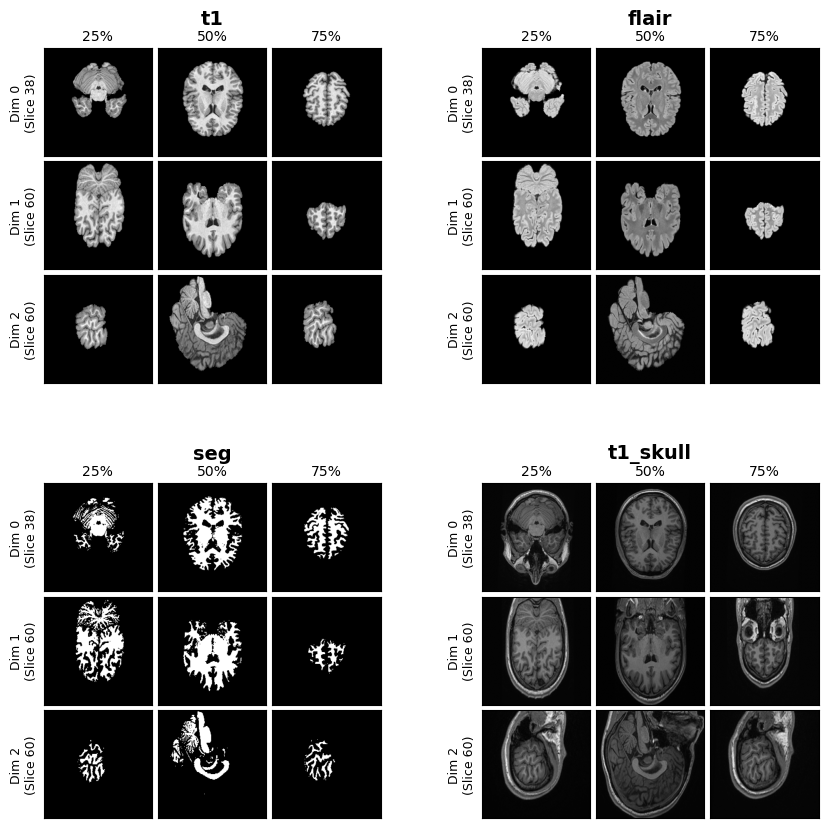

In [8]:
# resample to SRI24 and add T1 with skull for registration
study_with_seg_sri24 = study_with_seg.resample_to(study_sri24["t1"]).add("t1_skull", study_sri24["t1"])
study_with_seg_sri24.plot()

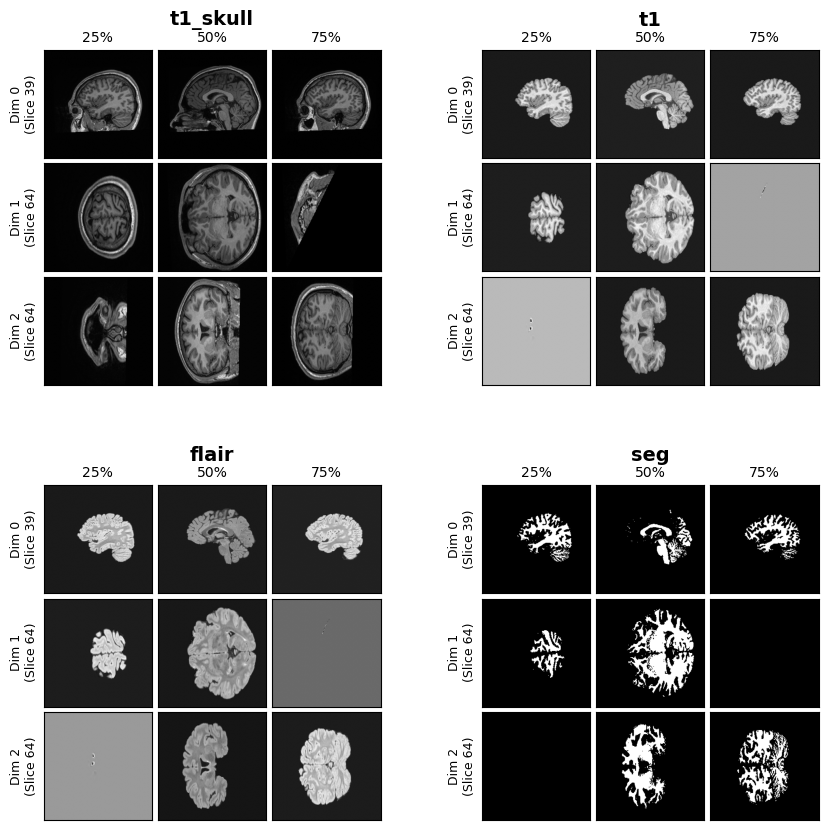

In [12]:
# register T1 with skull in SRI24 to the original T1 scan, all other scans and the segmentation will be transformed too
study_with_seg_orig = study_with_seg_sri24.register("t1_skull", study["t1"])
study_with_seg_orig.plot()

# Getting arrays out of a study
`study[key]` returns a `sitk.Image`.

To convert an image to numpy array, use `study.numpy(key)`.

To stack all images to a numpy array, use `study.stack_numpy(key)`. By default it stacks only scans, you can choose whether to include scans and segmentations by changing `scans` and `seg` arguments. The default order is alphabetical, but you can pass a custom order (a sequence of keys in desired order, like `["t1", "flair"]`).

In [13]:
t1 = study_with_seg_orig.numpy("t1")
print(f'{t1.shape = }')

stacked = study_with_seg_orig.stack_numpy(order=["t1", "flair"])
print(f'{stacked.shape = }')

t1.shape = (156, 256, 256)
stacked.shape = (2, 156, 256, 256)


# Saving/loading studies
Studies can be saved and loaded by using `study.save(dir)`, `study.load(dir)`, and `study.from_dir(dir)`. Studies are saved to directories, where each image is a *.nii.gz file which includes all spatial information. If there is info, it is serialized using pickle.

In [14]:
study_n4.save("saved")
print(os.listdir("saved"))

loaded = mrid.Study.from_dir("saved")
for k in study_n4.get_images():
    assert np.all(study_n4.numpy(k) == loaded.numpy(k))

['t1.nii.gz', 'flair.nii.gz', 'info_id.pkl']
